## Access Mooring Satellite Altimetry Calibration Validation data in Parquet
A jupyter notebook to show how to access and plot the AODN mooring_satellite_altimetry_calibration_validation dataset available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "mooring_satellite_altimetry_calibration_validation"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using Python 3.12.4 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 128 packages in 423ms


In [3]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

site_code: string
instrument: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'site_code')
print(list(unique_partition_value))  # showing a subset only

unique_partition_value = query_unique_value(parquet_ds, 'instrument')
print(list(unique_partition_value))  # showing a subset only

['SRSBASJAS', 'SRSBASS3B']
['Aquad', 'SBE37', 'SBE26', 'ST_CM']
CPU times: user 5.73 ms, sys: 1.03 ms, total: 6.77 ms
Wall time: 5.74 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

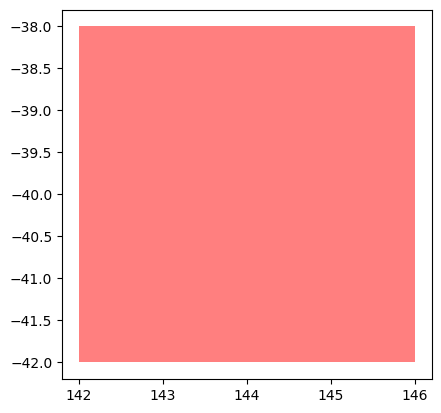

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2001, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site': {'type': 'string'},
 'instrument': {'type': 'string'},
 'instrument_serial_number': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'long_name': 'time',
  'standard_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0,
  'uncertainty': 1.1574074074074073e-05,
  'local_time_zone': '+10'},
 'LONGITUDE': {'type': 'float',
  'long_name': 'longitude',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'uncertainty': 0.0010000000474974513,
  'reference_datum': 'geographical coordinates, WGS84 projection'},
 'LATITUDE': {'type': 'float',
  'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'uncertainty': 0.0010000000474974513,
  'reference_datum': 'geographical coor

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2017-08-01', date_end='2018-06-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-45, lat_max=-28, lon_min=140, lon_max=160)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338229 entries, 0 to 338228
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   filename                  338229 non-null  object        
 1   site                      338229 non-null  object        
 2   instrument_serial_number  338229 non-null  object        
 3   TIME                      338229 non-null  datetime64[ns]
 4   LONGITUDE                 338229 non-null  float32       
 5   LATITUDE                  338229 non-null  float32       
 6   NOMINAL_DEPTH             338229 non-null  float32       
 7   TEMP                      338229 non-null  float32       
 8   TEMP_quality_control      338229 non-null  int32         
 9   UCUR                      4039 non-null    float32       
 10  UCUR_quality_control      4039 non-null    float32       
 11  VCUR                      4039 non-null    float32       
 12  VC

In [13]:
df['NOMINAL_DEPTH'].unique()

array([27.5, 49. , 50. , 17.5, 30. , 41.5, 28. ], dtype=float32)

/tmp/ipykernel_1195871/3299543.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap


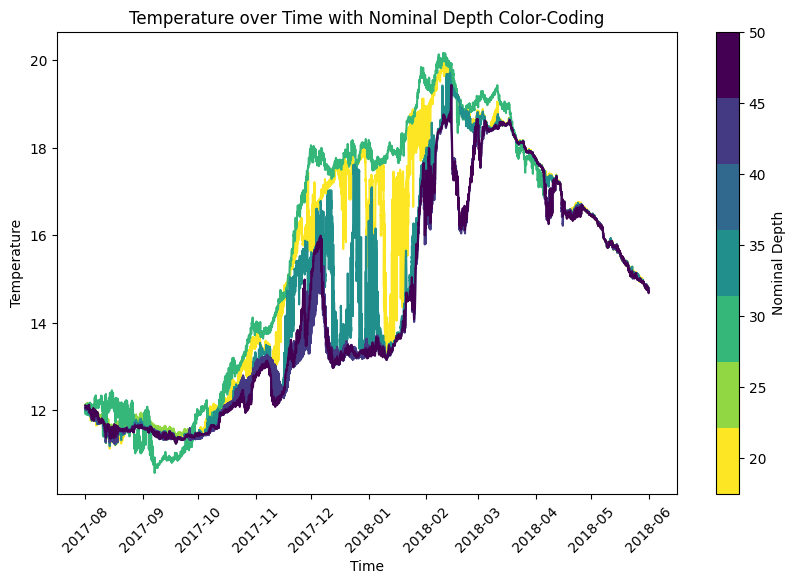

In [14]:
# Create a colormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

unique_depths = sorted(df['NOMINAL_DEPTH'].unique())
cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with color coding
for i, depth in enumerate(unique_depths):
    subset = df[df['NOMINAL_DEPTH'] == depth].sort_values('TIME')  # Sort by TIME
    ax.plot(subset['TIME'], subset['TEMP'], label=f'Depth {depth}', color=cmap(i / len(unique_depths)))

# Create a colorbar
norm = plt.Normalize(vmin=min(unique_depths), vmax=max(unique_depths))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Nominal Depth', orientation='vertical')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature over Time with Nominal Depth Color-Coding')
# Rotate the x-axis time labels to 45 degrees
plt.xticks(rotation=45)

plt.show()


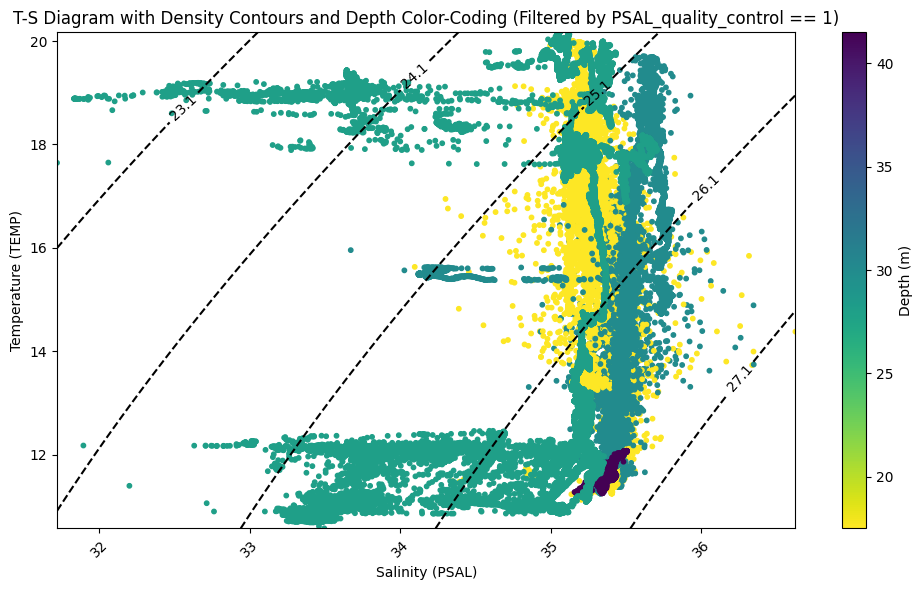

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import gsw  # TEOS-10 library
import matplotlib.cm as cm

# Filter data where PSAL_quality_control == 1 and PSAL >= 25 (some weird values of 16. to check)
filtered_df = df[(df['PSAL_quality_control'] == 1) & (df['PSAL'] >= 25)]

fig, ax = plt.subplots(figsize=(10, 6))

# Define the colormap for depth
depths = filtered_df['NOMINAL_DEPTH']
cmap = plt.get_cmap('viridis_r')  # Reverse the colormap to make deeper depths darker
norm = plt.Normalize(vmin=depths.min(), vmax=depths.max())  # Normalize the depth values for color mapping

# Plot the T-S diagram, color-coded by DEPTH
sc = ax.scatter(filtered_df['PSAL'], filtered_df['TEMP'], c=depths, cmap=cmap, norm=norm, s=10, label='Data')

# Generate temperature and salinity grids for contour plot
temp_range = np.linspace(filtered_df['TEMP'].min(), filtered_df['TEMP'].max(), 100)
psal_range = np.linspace(filtered_df['PSAL'].min(), filtered_df['PSAL'].max(), 100)
TEMP_grid, PSAL_grid = np.meshgrid(temp_range, psal_range)

# Compute density anomaly (sigma0) using gsw (pressure=0 for surface)
density = gsw.sigma0(PSAL_grid, TEMP_grid)  # Sigma0 = density anomaly (kg/m^3 - 1000)

# Plot density contours
density_levels = np.arange(density.min(), density.max(), 1)  # Customize levels if needed
contour = ax.contour(PSAL_grid, TEMP_grid, density, levels=density_levels, colors='k', linestyles='--')
ax.clabel(contour, fmt='%1.1f', fontsize=10)  # Add contour labels

# Create a colorbar for depth
cbar = plt.colorbar(sc, ax=ax, label='Depth (m)', orientation='vertical')

ax.set_xlabel('Salinity (PSAL)')
ax.set_ylabel('Temperature (TEMP)')
ax.set_title('T-S Diagram with Density Contours and Depth Color-Coding (Filtered by PSAL_quality_control == 1)')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Create a TIME and scalar/number filter

In [16]:
filter_time = create_time_filter(parquet_ds, date_start='2010-07-12', date_end='2012-02-05')

expr_1 = pc.field('site_code') == "SRSBASJAS"
filter = expr_1 & filter_time

In [17]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452574 entries, 0 to 452573
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   filename                  452574 non-null  object        
 1   site                      452574 non-null  object        
 2   instrument_serial_number  452574 non-null  object        
 3   TIME                      452574 non-null  datetime64[ns]
 4   LONGITUDE                 452574 non-null  float32       
 5   LATITUDE                  452574 non-null  float32       
 6   NOMINAL_DEPTH             452574 non-null  float32       
 7   TEMP                      452574 non-null  float32       
 8   TEMP_quality_control      452574 non-null  int32         
 9   UCUR                      0 non-null       float32       
 10  UCUR_quality_control      0 non-null       float32       
 11  VCUR                      0 non-null       float32       
 12  VC

In [18]:
df

,filename,site,instrument_serial_number,TIME,LONGITUDE,LATITUDE,NOMINAL_DEPTH,TEMP,TEMP_quality_control,UCUR,...,CNDC,CNDC_quality_control,PRES,PRES_quality_control,PSAL,PSAL_quality_control,site_code,instrument,timestamp,polygon
0,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:42:00.000000768,145.593002,-40.650002,52.0,17.007999,1,NaN,...,NaN,NaN,62.808132,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
1,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:47:00.000002816,145.593002,-40.650002,52.0,17.007999,1,NaN,...,NaN,NaN,62.838955,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
2,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:52:00.000005120,145.593002,-40.650002,52.0,17.009001,1,NaN,...,NaN,NaN,62.856396,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
3,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:57:00.000007424,145.593002,-40.650002,52.0,17.009001,1,NaN,...,NaN,NaN,62.883217,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
4,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 01:01:59.999999488,145.593002,-40.650002,52.0,17.010000,1,NaN,...,NaN,NaN,62.913002,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452569,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:20:00.000002304,145.591995,-40.641998,48.0,20.295099,1,NaN,...,4.88306,1.0,45.088001,1,35.483311,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
452570,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:29:59.999996672,145.591995,-40.641998,48.0,20.295200,1,NaN,...,4.88315,1.0,45.106998,1,35.483955,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
452571,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:40:00.000001024,145.591995,-40.641998,48.0,20.294001,1,NaN,...,4.88257,1.0,45.040001,1,35.480251,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
452572,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:49:59.999995648,145.591995,-40.641998,48.0,20.294901,1,NaN,...,4.88286,1.0,44.985001,1,35.481884,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
